In [1]:
! python.exe -m pip install --upgrade pip
! pip install pandas scikit-learn numpy

In [2]:
import pandas as pd

pd.set_option("future.no_silent_downcasting", True)

In [3]:
df = pd.read_csv('./Data/Clean_Dataset.csv')
df

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [6]:
df.isna().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [7]:
! pip install ydata-profiling sweetviz

In [8]:
import os

directory = 'EDA_reports'
if not os.path.exists(directory):
    os.makedirs(directory)

from ydata_profiling import ProfileReport

if not os.path.exists(directory + '/airline_pricing_profile_report.html'):
    report = ProfileReport(df, title='Airline Pricing Profile Report')
    report.to_file(os.path.join(directory, 'airline_pricing_profile_report.html'))

In [9]:
import sweetviz as sv

if not os.path.exists(directory + '/airline_pricing_sweetviz_report.html'):
    report = sv.analyze(df)
    # report.to_file(os.path.join(directory, 'airline_pricing_sweetviz_report.html'))
    report.show_html(filepath=directory + '/airline_pricing_sweetviz_report.html')

In [10]:
original_df = df.copy(deep=True)
original_df

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [11]:
df['airline'] = df['airline'].replace({
    'Vistara': 1,
    'Air_India': 2,
    'Indigo': 3,
    'GO_FIRST': 4,
    'AirAsia': 5,
    'SpiceJet': 6
})
df['source_city'] = df['source_city'].replace({
    'Delhi': 1,
    'Mumbai': 2,
    'Bangalore': 3,
    'Kolkata': 4,
    'Hyderabad': 5,
    'Chennai': 6
})
df['departure_time'] = df['departure_time'].replace({
    'Morning': 1,
    'Early_Morning': 2,
    'Evening': 3,
    'Night': 4,
    'Afternoon': 5,
    'Late_Night': 6
})
df['arrival_time'] = df['arrival_time'].replace({
    'Night': 1,
    'Evening': 2,
    'Morning': 3,
    'Afternoon': 4,
    'Early_Morning': 5,
    'Late_Night': 6
})
df['destination_city'] = df['destination_city'].replace({
    'Mumbai': 1,
    'Delhi': 2,
    'Bangalore': 3,
    'Kolkata': 4,
    'Hyderabad': 5,
    'Chennai': 6
})
df['stops'] = df['stops'].replace({
    'zero': 1,
    'one': 2,
    'two_or_more': 3
})
df['class'] = df['class'].replace({
    'Economy': 1,
    'Business': 2
})
df.drop(columns=['flight'], inplace=True)
df

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,6,1,3,1,1,1,1,2.17,1,5953
1,6,1,2,1,3,1,1,2.33,1,5953
2,5,1,2,1,5,1,1,2.17,1,5956
3,1,1,1,1,4,1,1,2.25,1,5955
4,1,1,1,1,3,1,1,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...
300148,1,6,1,2,2,5,2,10.08,49,69265
300149,1,6,5,2,1,5,2,10.42,49,77105
300150,1,6,2,2,1,5,2,13.83,49,79099
300151,1,6,2,2,2,5,2,10.00,49,81585


In [12]:
df.astype(float).describe()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000
mean,2.153072,3.201487,2.794901,1.924312,2.498846,3.268316,1.311464,12.221021,26.004751,20889.660523
std,1.348357,1.684757,1.401659,0.398106,1.407841,1.688644,0.463093,7.191997,13.561004,22697.767366
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.830000,1.000000,1105.000000
25%,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,6.830000,15.000000,4783.000000
50%,2.000000,3.000000,3.000000,2.000000,2.000000,3.000000,1.000000,11.250000,26.000000,7425.000000
75%,3.000000,5.000000,4.000000,2.000000,3.000000,5.000000,2.000000,16.170000,38.000000,42521.000000
max,6.000000,6.000000,6.000000,3.000000,6.000000,6.000000,2.000000,49.830000,49.000000,123071.000000


In [13]:
df = df.astype(float)

In [14]:
from scipy import stats

continuous_columns = ['duration', 'days_left', 'price']

for col in continuous_columns:
    df[col + "_zscore"] = stats.zscore(df[col])
    outlier_indices = df[abs(df[col + "_zscore"]) < 3].index
    mean_value = df[col].mean()
    df.loc[outlier_indices, col] = mean_value
    df.drop(columns=[col + '_zscore'], inplace=True)


## Generate new reports with preprocessed data

In [15]:
if not os.path.exists(directory + '/airline_pricing_profile_report_PROCESSED.html'):
    report = ProfileReport(df, title='Airline Pricing Profile Report')
    report.to_file(os.path.join(directory, 'airline_pricing_profile_report_PROCESSED.html'))

if not os.path.exists(directory + '/airline_pricing_sweetviz_report_PROCESSED.html'):
    report = sv.analyze(df)
    report.show_html(filepath=directory + '/airline_pricing_sweetviz_report_PROCESSED.html')

## Modelling

In [16]:
! pip install optuna lightgbm

In [17]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import optuna
import sys
from contextlib import contextmanager
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
import lightgbm

In [19]:


linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

y_pred = linear_regression_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

Mean Absolute Error (MAE): 363.74137827518047
Mean Squared Error (MSE): 12856702.010962488


In [20]:
# If an algorithm produces too many warning messages, skip them with this:
@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


def objective(trial, model_class, param_grid, X, y):
    params = {}
    for param, values in param_grid.items():
        if isinstance(values[0], int):
            params[param] = trial.suggest_int(param, min(values), max(values))
        elif isinstance(values[0], float):
            params[param] = trial.suggest_float(param, min(values), max(values))
        else:
            params[param] = trial.suggest_categorical(param, values)

    model_to_try = model_class(**params)
    score = cross_val_score(model_to_try, X, y, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    return -score.mean()

In [21]:
if not os.path.exists("Training Scores"):
    os.makedirs("Training Scores")

models = {
    'Linear Regression': {
        'model': LinearRegression,
        'param_grid': {}
    },
    'Random Forest': {
        'model': RandomForestRegressor,
        'param_grid': {
            'n_estimators': [40, 60, 100],
            'max_depth': [10, 20, 30],
            'min_samples_split': [3, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    #'Support Vector Machine': {        ## Takes way too long
    #    'model': SVR,
    #    'param_grid': {
    #        'C': [1, 10],
    #        'kernel': ['rbf', 'poly'],
    #        'gamma': ['scale', 'auto']
    #    }
    #},
    'Lasso': {
        'model': Lasso,
        'param_grid': {
            'alpha': [0.01, 0.1, 0.5, 1.0]
        }
    },
    'Ridge': {
        'model': Ridge,
        'param_grid': {
            'alpha': [0.01, 0.1, 0.5, 1.0],
        }
    },
    'LightGBM': {
        'model': lightgbm.LGBMRegressor,
        'param_grid': {
            'n_estimators': [10, 30, 60, 80, 100,
                             120, 140, 180, 200]
        }
    }
}

best_models = {}

X_train_subset = X_train  # [:10000]
y_train_subset = y_train  # [:10000]

if not os.path.exists('./Training Scores/Optuna_Scores.txt'):
    best_optuna_models = {}
    for model_name, model_info in models.items():
        model = model_info['model']
        param_grid = model_info['param_grid']

        print('NOW BEGINNING: ', model_name)
        study = optuna.create_study(direction='minimize',
                                    sampler=optuna.samplers.NSGAIISampler())
        study.optimize(
            lambda trial: objective(trial,
                                    model_info['model'],
                                    model_info['param_grid'],
                                    X_train_subset,
                                    y_train_subset),
            n_trials=100)
        best_optuna_models[model_name] = {'best_params': study.best_params, 'best_score': study.best_value}

    with open('./Training Scores/Optuna_Scores.txt', 'w') as f:
        f.write(str(best_optuna_models))


[I 2024-06-18 12:29:32,402] A new study created in memory with name: no-name-30b84451-831e-4fe8-8183-5786f75cb0e3


NOW BEGINNING:  Linear Regression


[I 2024-06-18 12:29:33,977] Trial 0 finished with value: 10475311.244980944 and parameters: {}. Best is trial 0 with value: 10475311.244980944.
[I 2024-06-18 12:29:34,984] Trial 1 finished with value: 10475311.244980944 and parameters: {}. Best is trial 0 with value: 10475311.244980944.
[I 2024-06-18 12:29:36,011] Trial 2 finished with value: 10475311.244980944 and parameters: {}. Best is trial 0 with value: 10475311.244980944.
[I 2024-06-18 12:29:37,034] Trial 3 finished with value: 10475311.244980944 and parameters: {}. Best is trial 0 with value: 10475311.244980944.
[I 2024-06-18 12:29:38,092] Trial 4 finished with value: 10475311.244980944 and parameters: {}. Best is trial 0 with value: 10475311.244980944.
[I 2024-06-18 12:29:39,070] Trial 5 finished with value: 10475311.244980944 and parameters: {}. Best is trial 0 with value: 10475311.244980944.
[I 2024-06-18 12:29:39,306] Trial 6 finished with value: 10475311.244980944 and parameters: {}. Best is trial 0 with value: 10475311.244

NOW BEGINNING:  Random Forest


[I 2024-06-18 12:30:04,135] Trial 0 finished with value: 9857991.123292135 and parameters: {'n_estimators': 46, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 9857991.123292135.
[I 2024-06-18 12:30:06,520] Trial 1 finished with value: 9851156.96337989 and parameters: {'n_estimators': 54, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 1 with value: 9851156.96337989.
[I 2024-06-18 12:30:10,619] Trial 2 finished with value: 9846802.972167991 and parameters: {'n_estimators': 97, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 2 with value: 9846802.972167991.
[I 2024-06-18 12:30:12,580] Trial 3 finished with value: 9838933.247531375 and parameters: {'n_estimators': 43, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 3 with value: 9838933.247531375.
[I 2024-06-18 12:30:16,274] Trial 4 finished with value: 9843074.11679327 and parameters: {'n_estimators':

NOW BEGINNING:  Lasso


[I 2024-06-18 12:35:01,132] Trial 0 finished with value: 10475314.067360928 and parameters: {'alpha': 0.4815770967566459}. Best is trial 0 with value: 10475314.067360928.
[I 2024-06-18 12:35:01,380] Trial 1 finished with value: 10475311.719458206 and parameters: {'alpha': 0.213052261553462}. Best is trial 1 with value: 10475311.719458206.
[I 2024-06-18 12:35:01,626] Trial 2 finished with value: 10475322.999850843 and parameters: {'alpha': 0.9566346289898877}. Best is trial 1 with value: 10475311.719458206.
[I 2024-06-18 12:35:01,861] Trial 3 finished with value: 10475311.635384679 and parameters: {'alpha': 0.19581670813790011}. Best is trial 3 with value: 10475311.635384679.
[I 2024-06-18 12:35:02,097] Trial 4 finished with value: 10475318.39748281 and parameters: {'alpha': 0.7516945550376698}. Best is trial 3 with value: 10475311.635384679.
[I 2024-06-18 12:35:02,344] Trial 5 finished with value: 10475319.442371503 and parameters: {'alpha': 0.8029690379122725}. Best is trial 3 with va

NOW BEGINNING:  Ridge


[I 2024-06-18 12:35:25,883] Trial 0 finished with value: 10475311.2429712 and parameters: {'alpha': 0.19411244050670137}. Best is trial 0 with value: 10475311.2429712.
[I 2024-06-18 12:35:26,109] Trial 1 finished with value: 10475311.238776742 and parameters: {'alpha': 0.6003755585895298}. Best is trial 1 with value: 10475311.238776742.
[I 2024-06-18 12:35:26,333] Trial 2 finished with value: 10475311.243573366 and parameters: {'alpha': 0.1359149072788685}. Best is trial 1 with value: 10475311.238776742.
[I 2024-06-18 12:35:26,560] Trial 3 finished with value: 10475311.23500705 and parameters: {'alpha': 0.9668224998561971}. Best is trial 3 with value: 10475311.23500705.
[I 2024-06-18 12:35:26,785] Trial 4 finished with value: 10475311.239701279 and parameters: {'alpha': 0.5106948772630303}. Best is trial 3 with value: 10475311.23500705.
[I 2024-06-18 12:35:27,008] Trial 5 finished with value: 10475311.240354672 and parameters: {'alpha': 0.4473605181192164}. Best is trial 3 with value: 

NOW BEGINNING:  LightGBM


[I 2024-06-18 12:35:50,697] Trial 0 finished with value: 9733984.170647843 and parameters: {'n_estimators': 81}. Best is trial 0 with value: 9733984.170647843.
[I 2024-06-18 12:35:51,455] Trial 1 finished with value: 9736892.495698763 and parameters: {'n_estimators': 64}. Best is trial 0 with value: 9733984.170647843.
[I 2024-06-18 12:35:52,063] Trial 2 finished with value: 9750733.048310492 and parameters: {'n_estimators': 29}. Best is trial 0 with value: 9733984.170647843.
[I 2024-06-18 12:35:52,693] Trial 3 finished with value: 9761784.865262603 and parameters: {'n_estimators': 24}. Best is trial 0 with value: 9733984.170647843.
[I 2024-06-18 12:35:53,561] Trial 4 finished with value: 9735317.689205306 and parameters: {'n_estimators': 88}. Best is trial 0 with value: 9733984.170647843.
[I 2024-06-18 12:35:54,598] Trial 5 finished with value: 9736759.921377257 and parameters: {'n_estimators': 169}. Best is trial 0 with value: 9733984.170647843.
[I 2024-06-18 12:35:55,247] Trial 6 fin

## Best optuna results

{'Linear Regression': {'best_params': {}, 'best_score': 26500973.916033458},
 'Random Forest': {'best_params': {'n_estimators': 63,
   'max_depth': 18,
   'min_samples_split': 5,
   'min_samples_leaf': 2},
  'best_score': 30022133.358639557},
 'Lasso': {'best_params': {'alpha': 0.9818794405133321},
  'best_score': 26499813.5938502},
 'Ridge': {'best_params': {'alpha': 0.9907901001005788},
  'best_score': 26499610.89094487},
 'LightGBM': {'best_params': {'n_estimators': 14},
  'best_score': 26536354.61283967}}

In [22]:
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'param_grid': {}
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'param_grid': {
            'n_estimators': [40, 60, 100],
            'max_depth': [10, 20, 30],
            'min_samples_split': [3, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    #'Support Vector Machine': {        ## Takes way too long
    #    'model': SVR,
    #    'param_grid': {
    #        'C': [1, 10],
    #        'kernel': ['rbf', 'poly'],
    #        'gamma': ['scale', 'auto']
    #    }
    #},
    'Lasso': {
        'model': Lasso(),
        'param_grid': {
            'alpha': [0.01, 0.1, 0.5, 1.0]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'param_grid': {
            'alpha': [0.01, 0.1, 0.5, 1.0],
        }
    },
    'LightGBM': {
        'model': lightgbm.LGBMRegressor(),
        'param_grid': {
            'n_estimators': [10, 30, 60, 80, 100,
                             120, 140, 180, 200]
        }
    }
}
if not os.path.exists('./Training Scores/GridSearchCV_Scores.txt'):
    for model_name, model_info in models.items():
        model = model_info['model']
        param_grid = model_info['param_grid']

        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1,
                                   scoring='neg_mean_squared_error', verbose=2)

        grid_search.fit(X_train_subset, y_train_subset)

        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_model = grid_search.best_estimator_

        # Store the best model and hyperparameters
        best_models[model_name] = {'best_params': best_params, 'best_model': best_model}

    X_test_subset = X_test  # [:10000]
    y_test_subset = y_test  # [:10000]
    highest_score = 0

    for model_name, model_info in best_models.items():
        best_model = model_info['best_model']
        y_pred_best = best_model.predict(X_test_subset)

        mae_best = mean_absolute_error(y_test_subset, y_pred_best)
        mse_best = mean_squared_error(y_test_subset, y_pred_best)
        r2_best = r2_score(y_test_subset, y_pred_best)

        print(f"{model_name} Metrics:")
        print(f"Mean Absolute Error (MAE): {mae_best:.2f}")
        print(f"Mean Squared Error (MSE): {mse_best:.2f}")
        print(f"R-squared (R2): {r2_best:.2f}")
        print(f"The parameters of the best model:\n{model_info['best_params']}")
        print()

    with open('./Training Scores/GridSearchCV_Scores.txt', 'w') as f:
        f.write(str(best_models))
        f.write(str(best_models))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 240122, number of used features: 8
[LightGBM] [Info] Start training from score 21031.822771
Linear Regression Metrics:
Mean Absolute Error (MAE): 363.74
Mean Squared Error (MSE): 12856702.01
R-squared (R2): 0.01
The parameters of the best model:
{}

Random Forest Metrics:
Mean Absolute Error (MAE): 284.79
Mean Squared Error (MSE): 11957382.99
R-squared (R2): 0.08
The parameters of

Linear Regression Metrics:  
Mean Absolute Error (MAE): 363.74  
Mean Squared Error (MSE): 12856702.01  
R-squared (R2): 0.01  
The parameters of the best model:  
{}  

Random Forest Metrics:  
Mean Absolute Error (MAE): 284.79  
Mean Squared Error (MSE): 11957382.99  
R-squared (R2): 0.08  
The parameters of the best model:  
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 60}  

Lasso Metrics:  
Mean Absolute Error (MAE): 363.72  
Mean Squared Error (MSE): 12856703.75  
R-squared (R2): 0.01  
The parameters of the best model:  
{'alpha': 0.01}  
  
Ridge Metrics:  
Mean Absolute Error (MAE): 363.74  
Mean Squared Error (MSE): 12856702.29  
R-squared (R2): 0.01  
The parameters of the best model:  
{'alpha': 1.0}  

LightGBM Metrics:  
Mean Absolute Error (MAE): 291.08  
Mean Squared Error (MSE): 11808686.37  
R-squared (R2): 0.09  
The parameters of the best model:  
{'n_estimators': 120}  

## Training best final model

In [23]:
best_lightGBM_params = {
    'n_estimators': 60
}

best_lightGBM_model = lightgbm.LGBMRegressor(**best_lightGBM_params)
best_lightGBM_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 240122, number of used features: 8
[LightGBM] [Info] Start training from score 21031.822771


LGBMRegressor(n_estimators=60)

In [24]:
y_pred = best_lightGBM_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Absolute Error (MAE): 290.2807753638244
Mean Squared Error (MSE): 11807003.581151346
R-squared (R2): 0.08672616858423154


Mean Absolute Error (MAE): 2451.6463877124097  
Mean Squared Error (MSE): 17319690.345978007  
R-squared (R2): 0.9664009972136046  

# TODO:
## - Optuna?
## - Check for duplicate data (not needed)
## - Anomaly Detection (won't be done)
## - Outlier Handling (DONE)
## - Neural Network Regression
## - dockerization (wasn't shown)

## - REST API building and testing

# Regression using neural networks

In [25]:
! pip install tensorflow

  Using cached tensorflow-2.16.1-cp312-cp312-win_amd64.whl.metadata (3.5 kB)
  Using cached tensorflow_intel-2.16.1-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp312-cp312-win_amd64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached ml_dtypes-0.3.2-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached protobuf-4.25.3-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.16.0-cp312-cp312-win_amd64.whl.metadata (

In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


def mean_absolute_percentage_error(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true), 1e-8, tf.float32.max))) * 100


early_stopping = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

optimizer = Adam(learning_rate=0.0005)

model = tf.keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(30, activation='relu'),
    #Dropout(0.3),
    Dense(30, activation='relu'),
    Dense(1, activation='linear')  # Linear activation for regression
])

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', mean_absolute_percentage_error])
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping], batch_size=64)

Epoch 1/50
3752/3752 ━━━━━━━━━━━━━━━━━━━━ 3s 562us/step - loss: 244242704.0000 - mean_absolute_percentage_error: 60.9413 - mse: 244242704.0000 - val_loss: 14029096.0000 - val_mean_absolute_percentage_error: 3.8427 - val_mse: 14029096.0000
Epoch 2/50
3752/3752 ━━━━━━━━━━━━━━━━━━━━ 2s 542us/step - loss: 12118995.0000 - mean_absolute_percentage_error: 3.4435 - mse: 12118995.0000 - val_loss: 13295548.0000 - val_mean_absolute_percentage_error: 2.1915 - val_mse: 13295548.0000
Epoch 3/50
3752/3752 ━━━━━━━━━━━━━━━━━━━━ 2s 540us/step - loss: 9381090.0000 - mean_absolute_percentage_error: 1.9104 - mse: 9381090.0000 - val_loss: 13081374.0000 - val_mean_absolute_percentage_error: 1.5125 - val_mse: 13081374.0000
Epoch 4/50
3752/3752 ━━━━━━━━━━━━━━━━━━━━ 2s 543us/step - loss: 11232759.0000 - mean_absolute_percentage_error: 1.4936 - mse: 11232759.0000 - val_loss: 13009296.0000 - val_mean_absolute_percentage_error: 1.3327 - val_mse: 13009296.0000
Epoch 5/50
3752/3752 ━━━━━━━━━━━━━━━━━━━━ 2s 539us/step

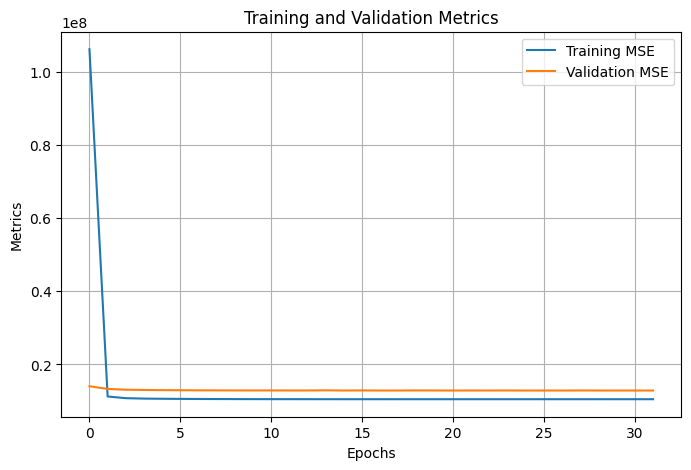

In [32]:
# Plot the training history for MSE and MAPE
plt.figure(figsize=(8, 5))

plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')


plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()

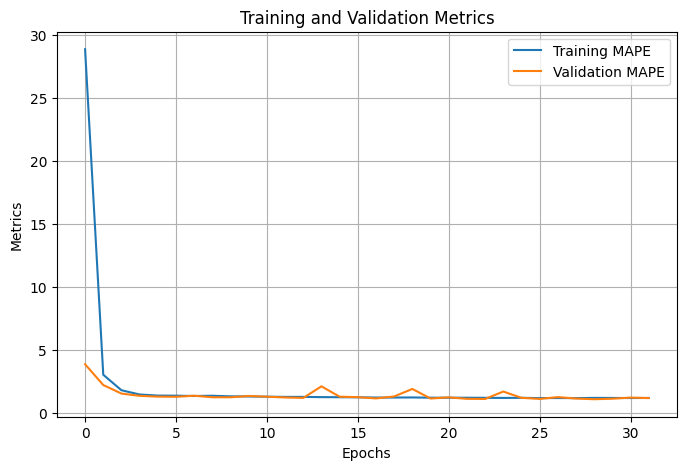

In [33]:
# Plot the training history for MSE and MAPE
plt.figure(figsize=(8, 5))

plt.plot(history.history['mean_absolute_percentage_error'], label='Training MAPE')
plt.plot(history.history['val_mean_absolute_percentage_error'], label='Validation MAPE')

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()

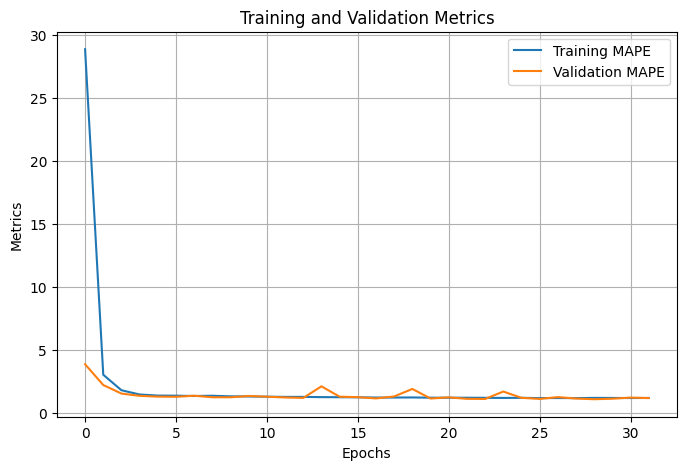

In [34]:
# Plot the training history for MSE and MAPE
plt.figure(figsize=(8, 5))

plt.plot(history.history['mean_absolute_percentage_error'], label='Training MAPE')
plt.plot(history.history['val_mean_absolute_percentage_error'], label='Validation MAPE')

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
import numpy as np

y_pred_test = model.predict(X_test, verbose=0)

y_test = y_test.values if isinstance(y_test, pd.Series) else y_test
y_pred_test = y_pred_test.flatten()

mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print("MAPE", mape_test)

MAPE 1.2274414827057791
